In [2]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
from pygimli.physics import ert
import pygimli.meshtools as mt

In [3]:
data = ert.load("example.dat")
print(data)

19/07/22 - 17:38:33 - pyGIMLi - INFO - could not read unified data format for ERT ... try res2dinv


Data: Sensors: 28 data: 421, nonzero entries: ['a', 'b', 'ip', 'm', 'n', 'rhoa', 'valid']


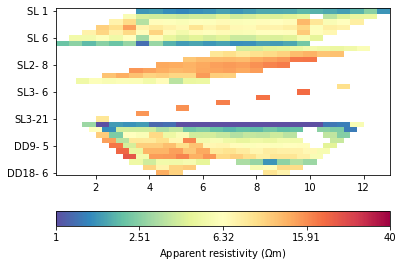

In [4]:
ert.show(data, cMin=1, cMax=40);

In [5]:
# if we already have resistance we don't need that
if not data.haveData("r"):
    data["k"] = ert.geometricFactors(data)
    data["r"] = data["rhoa"] / data["k"]

In [6]:
z0 = 0.05
dz = 0.5
ze = np.arange(data.sensorCount()) * dz + z0
print(ze)

[ 0.05  0.55  1.05  1.55  2.05  2.55  3.05  3.55  4.05  4.55  5.05  5.55
  6.05  6.55  7.05  7.55  8.05  8.55  9.05  9.55 10.05 10.55 11.05 11.55
 12.05 12.55 13.05 13.55]


In [7]:
for i in range(data.sensorCount()):
    data.setSensor(i, [0, 0, -ze[i]])

print(pg.z(data))

28 [-0.05, -0.55, -1.05, -1.55, -2.05, -2.55, -3.05, -3.55, -4.05, -4.55, -5.05, -5.55, -6.05, -6.55, -7.05, -7.55, -8.05, -8.55, -9.05, -9.55, -10.05, -10.55, -11.05, -11.55, -12.05, -12.55, -13.05, -13.55]


In [8]:
data["k"] = ert.geometricFactors(data, dim=3)

In [9]:
data["rhoa"] = data["r"] * data["k"]
data["err"] = ert.estimateError(data, relativeError=0.03, absoluteUError=100e-6)
print(max(data["err"]))

0.07130350945236023


c:\Program Files\software\Anaconda\envs\py38\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Program Files\software\Anaconda\envs\py38\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
19/07/22 - 17:38:38 - pyGIMLi - WARNING - Something gone wrong while drawing data. Try fallback with equidistant electrodes.


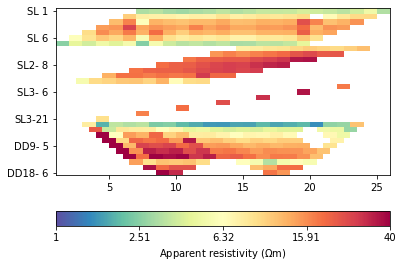

In [10]:
ert.show(data, cMin=1, cMax=40);

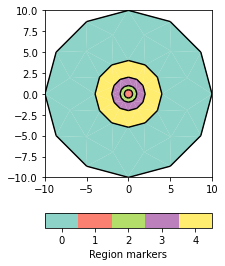

In [11]:
r = [0, 0.5, 1, 2, 4]
world = mt.createCircle(radius=10, marker=0, isClosed=True)
world.createNode([0, 0])
for b in world.boundaries():
    b.setMarker(-2)
for i in range(len(r)-1):
    circle = mt.createCircle(radius=r[i+1], marker=i+1, isClosed=True)
    world += circle

pg.show(world);

In [ ]:
mesh2d = mt.createMesh(world, quality=34)
pg.show(mesh2d, markers=True, showMesh=True);

In [ ]:
z = -np.arange(data.sensorCount()*2+6)*dz/2 - z0 + dz/2
z[0] = 0
z[-2] -= 1
z[-1] -=3
print(z)

In [1]:
mesh3d = mt.extrudeMesh(mesh2d, z)
print(mesh3d)
pg.show(mesh3d)
mesh3d.exportVTK("mesh3d.vtk")

NameError: name 'mt' is not defined

In [14]:
cz = np.unique(pg.z(mesh3d.cellCenters()))
print(cz)
# print(-cz/dz*2-z0*2)
print(np.ceil(-(cz+z0+.1)/ dz * 2))

[-16.925 -15.175 -14.425 -14.175 -13.925 -13.675 -13.425 -13.175 -12.925
 -12.675 -12.425 -12.175 -11.925 -11.675 -11.425 -11.175 -10.925 -10.675
 -10.425 -10.175  -9.925  -9.675  -9.425  -9.175  -8.925  -8.675  -8.425
  -8.175  -7.925  -7.675  -7.425  -7.175  -6.925  -6.675  -6.425  -6.175
  -5.925  -5.675  -5.425  -5.175  -4.925  -4.675  -4.425  -4.175  -3.925
  -3.675  -3.425  -3.175  -2.925  -2.675  -2.425  -2.175  -1.925  -1.675
  -1.425  -1.175  -0.925  -0.675  -0.425  -0.175  -0.025]
[68. 61. 58. 57. 56. 55. 54. 53. 52. 51. 50. 49. 48. 47. 46. 45. 44. 43.
 42. 41. 40. 39. 38. 37. 36. 35. 34. 33. 32. 31. 30. 29. 28. 27. 26. 25.
 24. 23. 22. 21. 20. 19. 18. 17. 16. 15. 14. 13. 12. 11. 10.  9.  8.  7.
  6.  5.  4.  3.  2.  1. -0.]


In [15]:
minz = pg.min(pg.z(data)) - 1
for c in mesh3d.cells():
    nlay = int(np.ceil(-(c.center().z()+z0)/(dz/2)))
    rad = np.sqrt(c.center().x()**2 + c.center().y()**2)
    if rad < r[-1]:
        c.setMarker(c.marker()*100 + nlay)

    if c.center().z() < minz:
        c.setMarker(0)
        
for b in mesh3d.boundaries():
    if b.outside():
        if b.center().z() == 0:
            b.setMarker(pg.core.MARKER_BOUND_HOMOGEN_NEUMANN)
        else:
            b.setMarker(pg.core.MARKER_BOUND_MIXED)
mesh3d.exportVTK("mesh3d.vtk")

In [37]:
#np.unique(mesh3d.cellMarkers())

In [17]:
mgr = ert.ERTManager(data, verbose=True)
mgr.setMesh(mesh3d)

12/05/22 - 18:34:55 - pyGIMLi - INFO - Found 237 regions.
12/05/22 - 18:34:55 - pyGIMLi - INFO - Region with smallest marker (0) set to background


In [31]:
mgr.inv.setRegularization("*", single=True)
mgr.inv.setRegularization(0, background=True)
mgr.fop.setInterRegionCoupling("*", "*", 1.0)

In [32]:
mgr.invert(robustData=True)

12/05/22 - 18:39:35 - pyGIMLi - INFO - Use median(data values)=13.015264252496994
12/05/22 - 18:39:35 - pyGIMLi - INFO - Created startmodel from forward operator: 236 [13.015264252496994,...,13.015264252496994]
12/05/22 - 18:39:35 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000160FE5CEFB0>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x00000160FE6482B0>
Model transformation (cumulative):
	 0 <pygimli.core._pygimli_.RTransLogLU object at 0x000001615284CC60>
	 1 <pygimli.core._pygimli_.RTransLogLU object at 0x000001615284CC60>
	 2 <pygimli.core._pygimli_.RTransLogLU object at 0x000001615284CC60>
	 3 <pygimli.core._pygimli_.RTransLogLU object at 0x000001615284CC60>
	 4 <pygimli.core._pygimli_.RTransLogLU object at 0x000001615284CC60>
	 5 <pygimli.core._pygimli_.RTransLogLU object at 0x000001615284CC60>
	 6 <pygimli.core._pygimli_.RTransLogLU object at 0x000001615284CC60>
	 7 <pygimli.core._pygimli_.RTransLogLU object at 0x000001615284CC60>
	 8 <pygimli.core._pygimli_.RTransLogLU object at 0x000001615284CC60>
	 9 <pygimli.core._pygimli_.RTransLogLU object at 0x000001615284CC60>
................................................................................................

9794 [23.850282107832655,...,47.70985898428075]

12/05/22 - 18:37:03 - pyGIMLi - WARNING - Something gone wrong while drawing data. Try fallback with equidistant electrodes.
12/05/22 - 18:37:04 - pyGIMLi - WARNING - Something gone wrong while drawing data. Try fallback with equidistant electrodes.


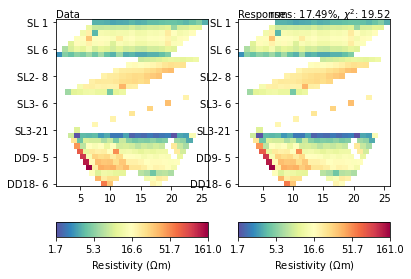

In [25]:
mgr.showFit();

12/05/22 - 18:36:28 - pyGIMLi - WARNING - Something gone wrong while drawing data. Try fallback with equidistant electrodes.


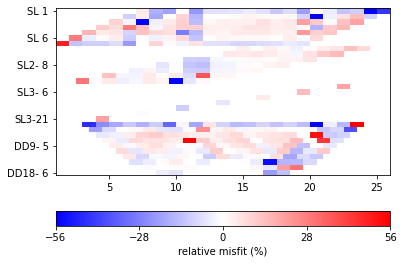

In [21]:
mgr.showMisfit()

In [22]:
mgr.saveResult()

12/05/22 - 18:36:29 - pyGIMLi - INFO - Saving resistivity data to: .\20220512-18.36\ERTManager


'.\\20220512-18.36\\ERTManager'

In [26]:
#zz = -np.arange(data.sensorCount()+3)*dz -z0 + dz/2
#zz[0] = 0
#print(zz)
zz = z[:-2]
grid = mt.createGrid(zz, r)
print(grid, len(mgr.model))
grid.swapCoordinates(0, 1)
# pg.show(grid)

Mesh: Nodes: 300 Cells: 236 Boundaries: 535 236


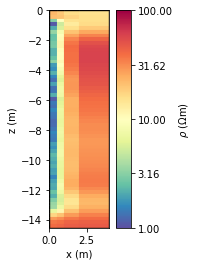

In [36]:
pg.show(grid, mgr.model, cMin=1, cMax=100, xlabel="x (m)", ylabel="z (m)",
        label=r"$\rho$ ($\Omega$m)", cMap="Spectral_r", logScale=True, orientation="vertical");